# Notebook for annotating the trees in the images and saving the predictions

What is saved?

- Currently only 200 files for testing purposes (of a difficult part of the video, many overlapping trees on the right side)

Folder structure of saved files:
- annotated_05 (we take 1 out of every 5 frames)
    - eastbound
        - eastbound_20240319_07816.png (annotated image)
        - eastbound_20240319_07816.json
            - bounding boxes
            - certainty scores
            - predicted keypoints
            - file_name to pred_masks
            - file_name to pred_keypoint_heatmaps
        - eastbound_20240319_07816_pred_mask.npy
        - eastbound_20240319_07816_pred_keypoints_heatmaps.npy


## Before running this notebook

You need the undestorted_05.zip, or you can create these files by running undistored_images_camera_calibration_frame_extraction.ipynb (takes very long).

undestorted_05.zip link: https://ugentbe-my.sharepoint.com/:f:/g/personal/thomas_dirven_ugent_be/Eu76kcdu3HJJsbQwTMyyDZwBH_quW09UIMCKP4AFmAiJtA?e=wROqbx

Create this folder sturcture and insert files:
- assets
    - (unpack undestorted_05.zip in here, content should look like below)
    - undestorted_05 
        - eastbound
            - eastbound_20240319_07816.png (example file)
            - eastbound_20240319_xxxxx.png (example file)
- output
    - image_00000_RGB.png (from PercepTreeV1 github, optional image for demo testing)
    - ResNext-101_fold_01.pth (from PercepTreeV1 github)

## If you do not want to run this notebook

Notebook with output can be found in shared onedrive

Output files can be found in annotated_05.zip

annotated_05.zip link: https://ugentbe-my.sharepoint.com/:f:/g/personal/thomas_dirven_ugent_be/Eu76kcdu3HJJsbQwTMyyDZwBH_quW09UIMCKP4AFmAiJtA?e=wROqbx

In [1]:
!pip install opencv-python

In [2]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-tiwxvcql
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-tiwxvcql
  Resolved https://github.com/facebookresearch/detectron2.git to commit b7c7f4ba82192ff06f2bbb162b9f67b00ea55867
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.7/463.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 40.

In [77]:
from __future__ import  absolute_import

# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

import os
import cv2
import torch
import json
import gc

from glob import glob
import matplotlib.pyplot as plt
import numpy as np

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.video_visualizer import VideoVisualizer

[04/12 21:59:06 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/ResNext-101_fold_01.pth ...


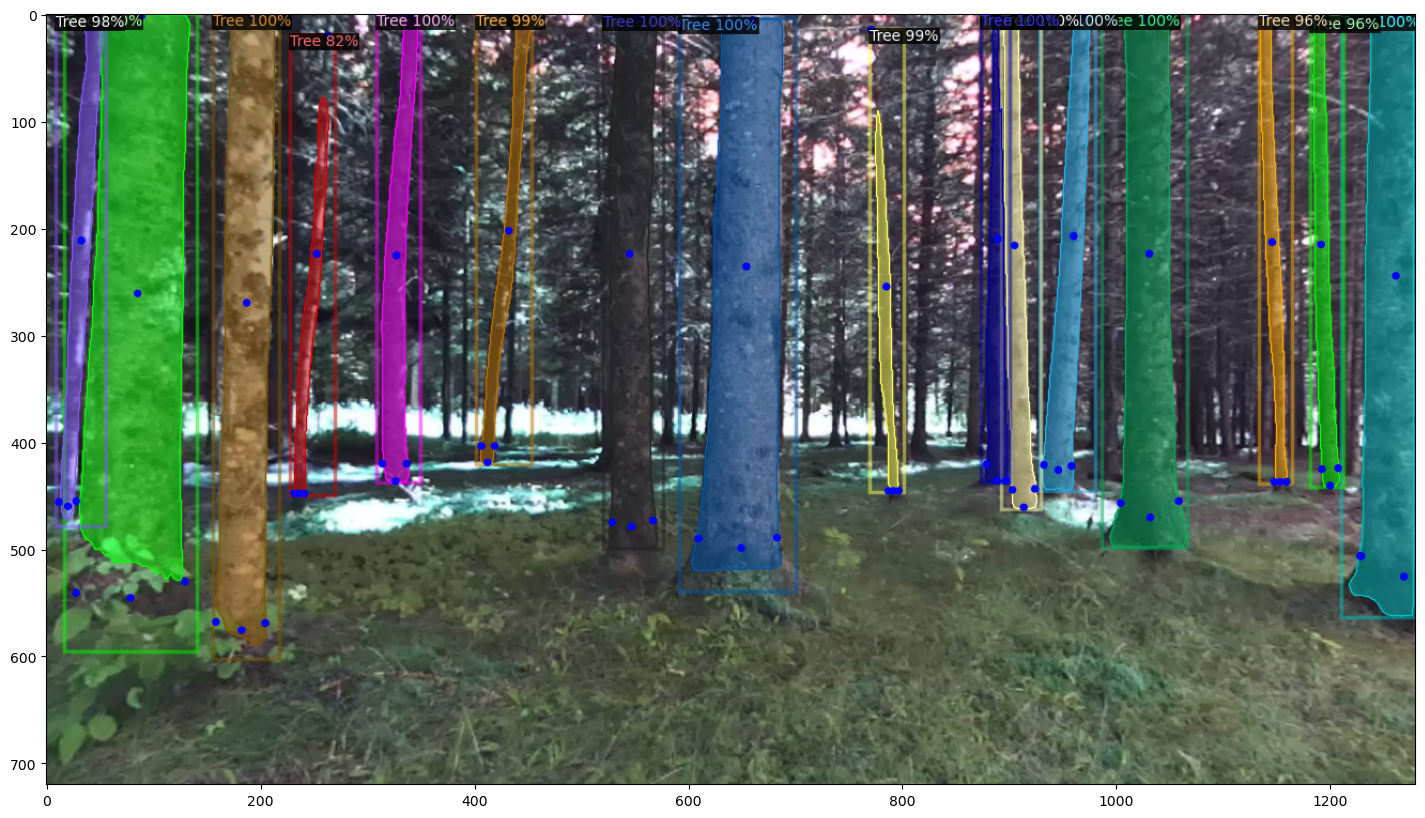

In [7]:
# Code from PercepTreeV1 use as test demo

# local paths to model and image
# model_name = 'X-101_RGB_60k.pth'
# model_name = 'R-50_RGB_60k.pth'
model_name = 'ResNext-101_fold_01.pth'
image_path = './output/image_00000_RGB.png'

if __name__ == "__main__":
    torch.cuda.is_available()
    logger = setup_logger(name=__name__)
    
    # All configurables are listed in /repos/detectron2/detectron2/config/defaults.py        
    cfg = get_cfg()
    cfg.INPUT.MASK_FORMAT = "bitmask"
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ()
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 8
    cfg.SOLVER.IMS_PER_BATCH = 8
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (tree)
    cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1  
    cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 5
    cfg.MODEL.MASK_ON = True
    
    cfg.OUTPUT_DIR = './output'
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_name)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    # cfg.INPUT.MIN_SIZE_TEST = 0  # no resize at test time
    
    # set detector
    predictor_synth = DefaultPredictor(cfg)    
    
    # set metadata
    tree_metadata = MetadataCatalog.get("my_tree_dataset").set(thing_classes=["Tree"], keypoint_names=["kpCP", "kpL", "kpR", "AX1", "AX2"])
    
    # inference
    im = cv2.imread(image_path)
    outputs_pred = predictor_synth(im)
    v_synth = Visualizer(im[:, :, ::-1],
                    metadata=tree_metadata, 
                    scale=1,
    )
    out_synth = v_synth.draw_instance_predictions(outputs_pred["instances"].to("cpu"))

    # Assuming out_synth.get_image() returns the image
    image = out_synth.get_image()[:, :, ::-1]  # Assuming the image is in BGR format, converting it to RGB
    
    plt.figure(figsize=(20, 10))
    plt.imshow(image)
    # plt.axis('off')  # Turn off axis
    plt.show()

    # Original code from demo, but this give errors in online notebooks, using above matplotlib instead
    # cv2.imshow('predictions', out_synth.get_image()[:, :, ::-1])
    # k = cv2.waitKey(0)
    
    # cv2.destroyAllWindows()  
        

In [8]:
predictions = outputs_pred["instances"].to("cpu")

In [42]:
# List all attributes of predictions (which is of class Instance)
# Also read these detectron2 docs for further info
# https://detectron2.readthedocs.io/en/latest/_modules/detectron2/structures/instances.html

# dir(predictions)

In [33]:
num_instances = len(predictions.pred_boxes)
image_height = predictions.image_size[0]
image_width = predictions.image_size[1]

print(num_instances)
print(image_height)
print(image_width)

16
720
1280


In [68]:
# Usefull overview of all data

# predictions.get_fields()

Boxes:
- [ $L_{x}$, $L_{y}$, $R_{x}$, $R_{y}$ ]
- Upper_Left(x,y), Bottom_Right(x,y)

If y==0 you are at the top of the image,  
y increases when you go down.

In [73]:
predictions.get("pred_boxes").tensor.tolist()

[[592.4595336914062, 4.335380554199219, 701.0404052734375, 540.0097045898438],
 [987.2096557617188, 0.0, 1067.2572021484375, 499.1213684082031],
 [928.68896484375, 0.0, 980.5079956054688, 446.12933349609375],
 [1211.2713623046875, 1.42312490940094, 1278.6348876953125, 563.969482421875],
 [520.5076904296875, 1.3991308212280273, 576.5972290039062, 499.8786315917969],
 [17.100452423095703, 0.0, 140.8750457763672, 596.3302612304688],
 [155.5316619873047, 0.0, 217.93687438964844, 602.5341186523438],
 [309.1933898925781, 0.0, 350.2056884765625, 438.2436218261719],
 [892.7281494140625, 0.0, 929.9287719726562, 462.6879577636719],
 [874.2659912109375, 0.0, 900.87548828125, 437.77691650390625],
 [401.9212951660156, 0.0, 454.0411682128906, 420.72662353515625],
 [770.1480102539062, 13.50796890258789, 802.3895263671875, 447.3498229980469],
 [8.64796257019043, 1.2016699314117432, 55.65828323364258, 478.9849548339844],
 [1182.2945556640625, 3.0112059116363525, 1213.38623046875, 442.4242858886719],
 [

Prediction keypoints (x,y,(z??)):
- felling cut (middelste punt onderaan)
- diameter left (most left point of tree)
- diameter right (most right point of tree)
- tree middle (in camera view)
- tree top (in camera view)

In [48]:
# Just showing the first two sets of 5 keypoints

predictions.get("pred_keypoints").tolist()[:2]

[[[650.0836181640625, 499.2101745605469, 1.3582713603973389],
  [610.0801391601562, 490.5702819824219, 1.4179165363311768],
  [683.4198608398438, 489.6102600097656, 1.605761170387268],
  [654.845947265625, 236.17294311523438, 1.30130934715271],
  [660.5607299804688, 5.775365829467773, 1.2942893505096436]],
 [[1032.4747314453125, 470.8058166503906, 1.06129789352417],
  [1004.8391723632812, 457.367919921875, 0.743923008441925],
  [1059.1572265625, 455.4482421875, 1.8372182846069336],
  [1031.521728515625, 224.1246795654297, 0.8901503086090088],
  [1027.7099609375, 1.4397732019424438, 0.9105949401855469]]]

In [71]:
# .tolist() on a tensor is extremely slow, so saved it as npy instead (you can test this in a seperate cell and see how slow it is)
# pred_masks_list = predictions.get("pred_masks_list").tolist()
# pred_keypoints_heatmaps_list = predictions.get("pred_keypoint_heatmaps").tolist()

# This is why this data will be stored as .npy files

In [80]:
# Some global vars (temp location, will be moved into function call, def process_list_of_images(display_image, some_other_vars,...): )
display_image = True

# local paths to model and image
# model_name = 'X-101_RGB_60k.pth'
model_name = 'ResNext-101_fold_01.pth'
base_path = './assets/undestorted_05/eastbound'
image_dir_pattern = base_path + '/*.png'
output_dir = './assets/annotated_05/eastbound/'

# Ensure that the output directory exists, create it if necessary
os.makedirs(output_dir, exist_ok=True)

image_paths = glob(image_dir_pattern)
image_paths.sort()
print("Images to process:", len(image_paths))

# def process_list_of_images():
torch.cuda.is_available()
logger = setup_logger(name=__name__)

# All configurables are listed in /repos/detectron2/detectron2/config/defaults.py        
cfg = get_cfg()
cfg.INPUT.MASK_FORMAT = "bitmask"
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
# cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ()
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (tree)
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1  
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 5
cfg.MODEL.MASK_ON = True

cfg.OUTPUT_DIR = './output'
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_name)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
# cfg.INPUT.MIN_SIZE_TEST = 0  # no resize at test time

# set detector
predictor_synth = DefaultPredictor(cfg)    

# set metadata
tree_metadata = MetadataCatalog.get("my_tree_dataset").set(thing_classes=["Tree"], keypoint_names=["kpCP", "kpL", "kpR", "AX1", "AX2"])

for image_path in image_paths:    
    file_name = image_path.split("/")[-1]
    output_path = output_dir + file_name
    # inference
    im = cv2.imread(image_path)
    outputs_pred = predictor_synth(im)
    v_synth = Visualizer(im[:, :, ::-1],
                    metadata=tree_metadata, 
                    scale=1,
    )
    predictions = outputs_pred["instances"].to("cpu")
    out_synth = v_synth.draw_instance_predictions(predictions)

    # Assuming out_synth.get_image() returns the image
    image = out_synth.get_image()[:, :, ::-1]  # Assuming the image is in BGR format, converting it to RGB
    
    # Save the image
    cv2.imwrite(output_path, image)
    print("Succesfully wrote image to:", output_path)
    
    # Convert the tensors to lists
    pred_boxes_list = predictions.get("pred_boxes").tensor.tolist()
    scores_list = predictions.get("scores").tolist()
    pred_keypoints_list = predictions.get("pred_keypoints").tolist()
    
    # .tolist() on a tensor is extremely slow, so saved it as npy instead (you can test this in a seperate cell and see how slow it is)
    # pred_masks_list = predictions.get("pred_masks_list").tolist()
    # pred_keypoints_heatmaps_list = predictions.get("pred_keypoint_heatmaps").tolist()
    pred_mask_numpy = predictions.get("pred_masks").numpy()
    pred_keypoint_heatmaps_numpy = predictions.get("pred_keypoint_heatmaps").numpy()

    # File base name
    file_base_name = file_name.split(".png")[0]
    # File names are kept in json as reference to numpy array file
    pred_masks_file_name = file_base_name + '_pred_mask.npy'
    pred_keypoint_heatmaps_file_name = file_base_name + '_pred_keypoints_heatmaps.npy'
    # Create full path that is used for saving the .npy files
    pred_mask_numpy_path = output_dir + pred_masks_file_name
    pred_keypoint_heatmaps_numpy_path = output_dir + pred_keypoint_heatmaps_file_name
    # Save the .npy arrays
    print("Saving:", pred_mask_numpy_path)
    np.save(pred_mask_numpy_path, pred_mask_numpy)
    print("Saving:", pred_keypoint_heatmaps_numpy_path)
    np.save(pred_keypoint_heatmaps_numpy_path, pred_keypoint_heatmaps_numpy)
    
    # Prepare a dictionary for JSON serialization
    json_data = {
        "pred_boxes": pred_boxes_list,
        "scores": scores_list,
        "pred_keypoints": pred_keypoints_list,
        "pred_masks": pred_masks_file_name,
        "pred_keypoint_heatmaps": pred_keypoint_heatmaps_file_name,
    }
    
    # Save to a JSON file    
    file_base_name = file_name.split(".png")[0]
    json_path = output_dir + file_base_name + '.json'
    with open(json_path, 'w') as json_file:
        json.dump(json_data, json_file, indent=4)
    
    print(f"Data has been saved to {json_path}")    

    if display_image:        
        plt.figure(figsize=(20, 10))
        plt.imshow(out_synth.get_image())
        # plt.axis('off')  # Turn off axis
        plt.show()

    collected_garbage = gc.collect()
    print("Removed garbage:", collected_garbage)
    

In [ ]:
# Code used for video data - We are currently not using this (and are not planning to use it, I guess, individual frames might give better results)

#  model and video variables
model_name = 'R-50_RGB_60k.pth'
# model_name = 'X-101_RGB_60k.pth'
video_path = './output/forest_walk_1min.mp4'

if __name__ == "__main__":
    torch.cuda.is_available()
    logger = setup_logger(name=__name__)
    
    # All configurables are listed in /repos/detectron2/detectron2/config/defaults.py        
    cfg = get_cfg()
    cfg.INPUT.MASK_FORMAT = "bitmask"
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
    # cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_101_FPN_3x.yaml"))
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
    cfg.DATASETS.TRAIN = ()
    cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 8
    cfg.SOLVER.IMS_PER_BATCH = 8
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster (default: 512)
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (tree)
    cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 1  
    cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 5
    cfg.MODEL.MASK_ON = True
    
    cfg.OUTPUT_DIR = './output' 
    cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, model_name)
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    # cfg.INPUT.MIN_SIZE_TEST = 0  # no resize at test time
    
    # set detector
    predictor_synth = DefaultPredictor(cfg)    
    
    # set metadata
    tree_metadata = MetadataCatalog.get("my_tree_dataset").set(thing_classes=["Tree"], keypoint_names=["kpCP", "kpL", "kpR", "AX1", "AX2"])
            
    # Get one video frame 
    vcap = cv2.VideoCapture(video_path)
    
    # get vcap property 
    w = int(vcap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(vcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(vcap.get(cv2.CAP_PROP_FPS))
    n_frames = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # VIDEO recorder
    # Grab the stats from image1 to use for the resultant video
    # fourcc = cv2.VideoWriter_fourcc(*'mp4v')   
    # video = cv2.VideoWriter("pred_and_track_00.mp4",fourcc, 5, (w, h))  
    
    # Check if camera opened successfully
    if (vcap.isOpened()== False):
        print("Error opening video stream or file")
       
    vid_vis = VideoVisualizer(metadata=tree_metadata)
                                
    nframes = 0
    while(vcap.isOpened() ):
        ret, frame = vcap.read()
        # if frame is read correctly ret is True
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        y = 000
        # h = 800
        x = 000
        # w = 800
        crop_frame = frame[y:y+h, x:x+w]
        # cv2.imshow('frame', crop_frame)
        if cv2.waitKey(1) == ord('q'):
                break
        
        # 5 fps
        if nframes % 12 == 0:
            outputs_pred = predictor_synth(crop_frame)s
            # v_synth = Visualizer(crop_frame[:, :, ::-1],
            #                     metadata=tree_metadata, 
            #                     scale=1, 
            #                     instance_mode =  ColorMode.IMAGE     # remove color from image, better see instances  
            #     )
            out = vid_vis.draw_instance_predictions(crop_frame, outputs_pred["instances"].to("cpu"))
                
            vid_frame = out.get_image()
            # video.write(vid_frame)
            # cv2.imshow('frame', vid_frame)

            # Assuming out_synth.get_image() returns the image
            image = out_synth.get_image()[:, :, ::-1]  # Assuming the image is in BGR format, converting it to RGB
            
            plt.imshow(vid_frame)
            plt.axis('off')  # Turn off axis
            plt.show()
            
        nframes += 1
    
    # video.release()
    vcap.release()
    # cv2.destroyAllWindows()